In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from models.ICA_EM import *
import importlib, sys
from models.metrics import *
from models.source_estimator import *
importlib.reload(sys.modules['models.ICA_EM'])

<module 'models.ICA_EM' from '/Users/marvinlob/Documents/coding/eth/semester_project/models/ICA_EM.py'>

In [15]:
J = 6
I = J-1
n = 10000
std = 1
A = np.random.uniform(low = -3, high = 3, size = (I,J))
# introduce some zeros
#A[0,1] = 0
#A[1,3] = 0
#A[2,4] = 0
#A[2,3] = 0

S = np.random.laplace(size = (J,n), scale = 1/np.sqrt(2)) 
#S = np.random.uniform(low = -3, high = 3, size = (J,n))
X = (A @ S).T
X = X + np.random.normal(scale = std, size = X.shape)

In [16]:
overEM = OverICA_EM( iterations= 100, beta = 10, true_A=A, init_range= [-3,3])
overEM.fit(X, J, noise_params = {'mean': 0, 'std': std if std > 0 else 1}) # if std = 0, then we still need to pass 1 to avoid division by zero

Initializing A with true A + noise


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


In [17]:
varEM = VarEM( max_iter = 200, update_sigma = False, true_A=A, init_range= [-3,3], tol= 1e-3    )
varEM.fit(X, J, noise_params = {'mean': 0, 'std': std})

Initializing A with true A + noise


Diff: 0.0025: 100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 96356.54it/s]


In [18]:
print("Matrix estimation")
print("OverEM")
best_permuOverEM, score = f_score(A, overEM.A)
print("F-score: ", score)
print("VarEM")
best_permuVarEM, score = f_score(A, varEM.A)
print("F-score: ", score)

Matrix estimation
OverEM
F-score:  0.7033718284918067
VarEM
F-score:  0.0320366437872593


In [19]:
print("Source estimation")
print("OverEM")
score = likelihood_score(S.T, overEM.Signals)
mse = mean_squared_error(S.T, overEM.Signals)
print("Likelihood score: ", score)
print("MSE: ", mse)
print("VarEM")
score = likelihood_score(S.T, varEM.Signals)
mse = mean_squared_error(S.T, varEM.Signals)
print("Likelihood score: ", score)
print("MSE: ", mse)

Source estimation
OverEM
Likelihood score:  12830.095011865385
MSE:  1.3577112984860829
VarEM
Likelihood score:  -5884.537550993176
MSE:  0.6132719358101254


In [20]:
# plot signals righltly ordered
singals_estimation_VAR = varEM.Signals[:,best_permuVarEM]
A_mat_estimation_VAR = varEM.A[:,best_permuVarEM]
singals_estimation_OVER = overEM.Signals[:,best_permuOverEM]
A_mat_estimation_OVER = overEM.A[:,best_permuOverEM]


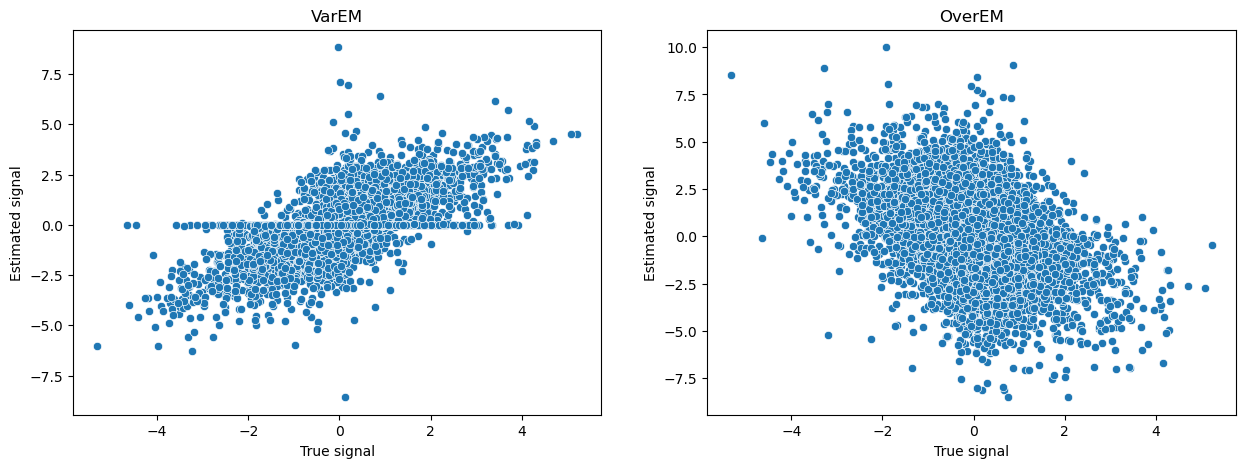

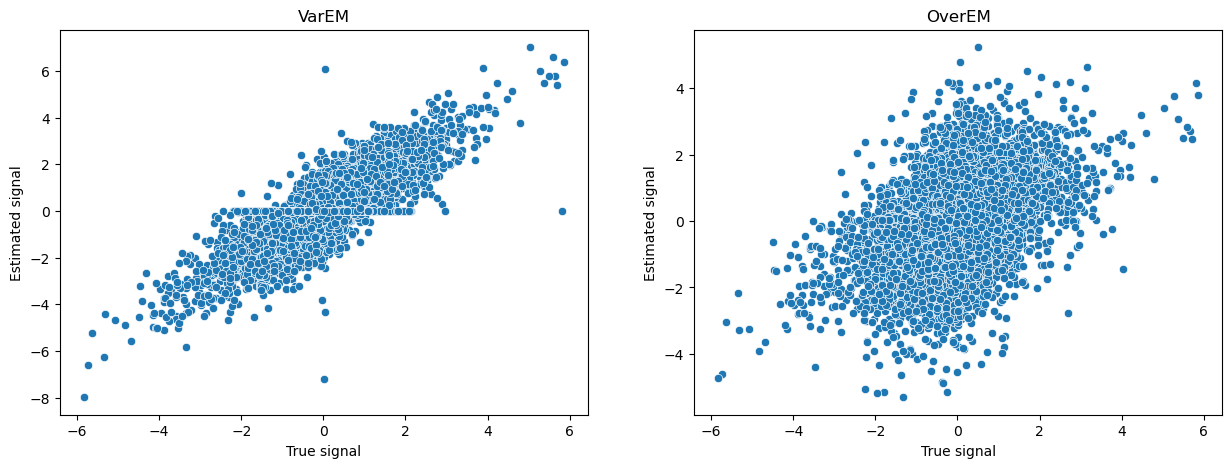

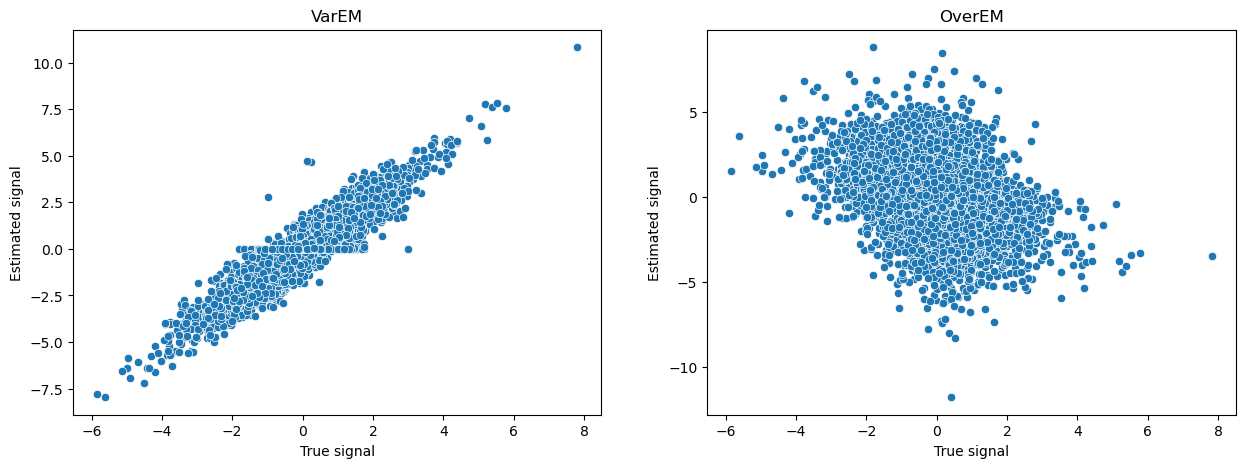

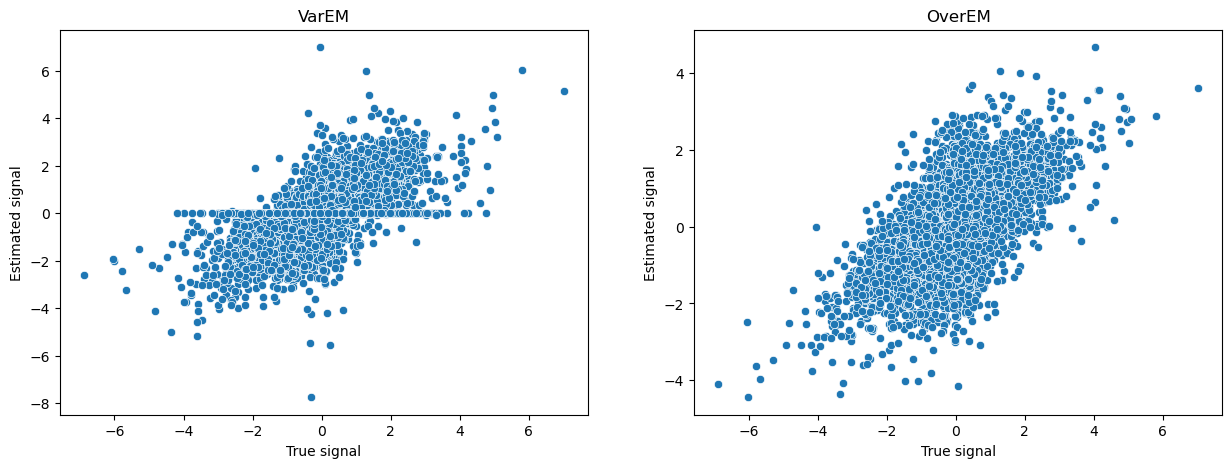

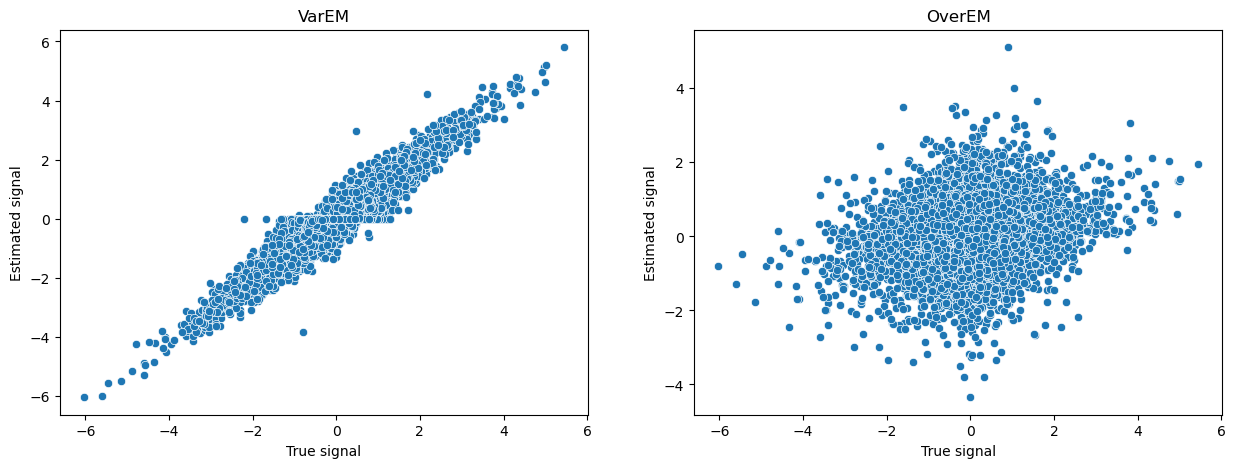

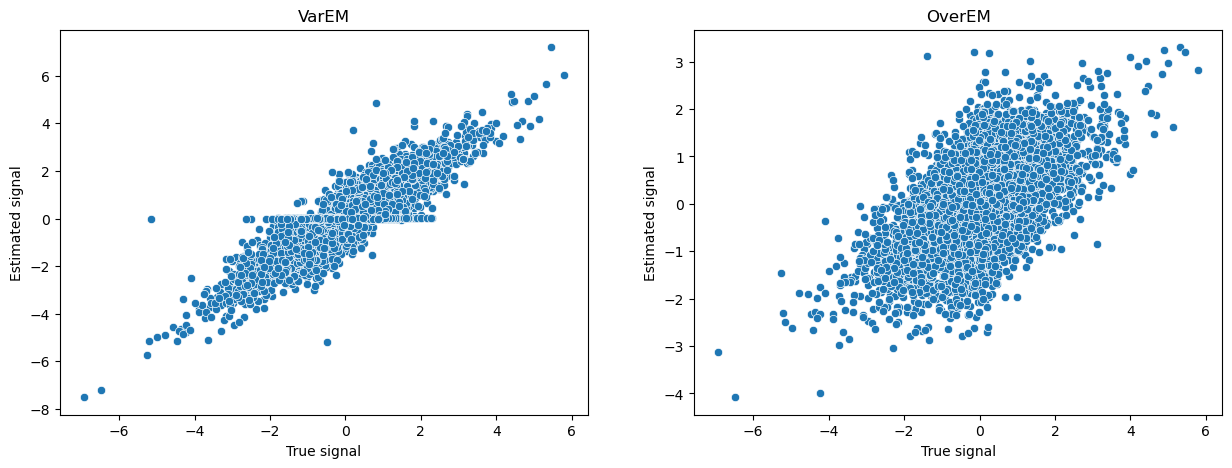

In [21]:
for i in range(J):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    sns.scatterplot(x = S.T[:,i], y = singals_estimation_VAR[:,i], ax = ax[0])
    sns.scatterplot(x = S.T[:,i], y = singals_estimation_OVER[:,i], ax = ax[1])
    ax[0].title.set_text('VarEM')
    ax[1].title.set_text('OverEM')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    
    plt.show()


In [22]:
sc_est = SourceEstimator(noise= True)
sc_est.fit(X, A_mat_estimation_VAR)


Fitting the model to the data in the noisy case


In [23]:
# Calculate new score methods
print("Source estimation")
print("VarEM")
score = likelihood_score(S.T, sc_est.Signals)
mse = mean_squared_error(S.T, sc_est.Signals)
print("Likelihood score: ", score)
print("MSE: ", mse)

Source estimation
VarEM
Likelihood score:  -5308.11347130152
MSE:  0.37577093840209475


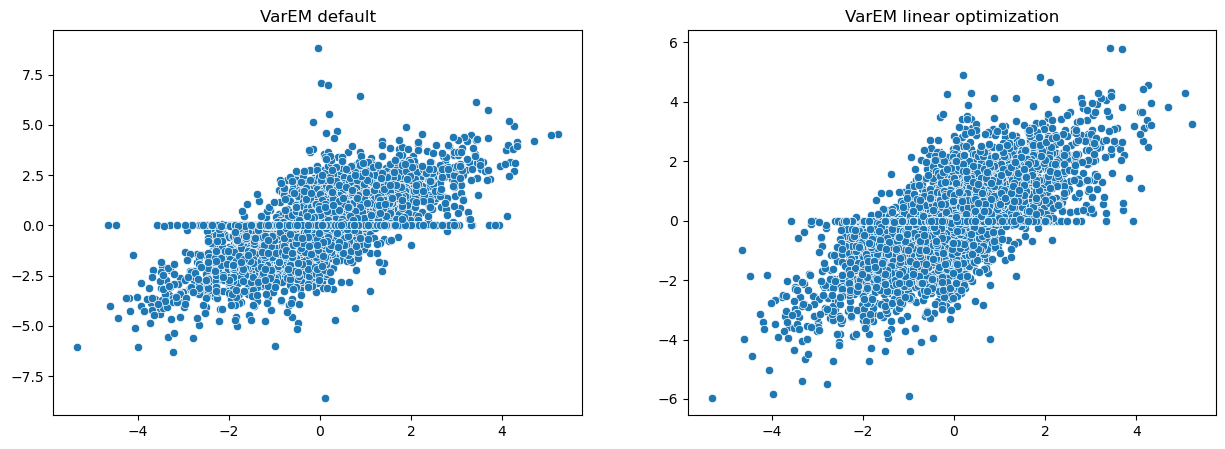

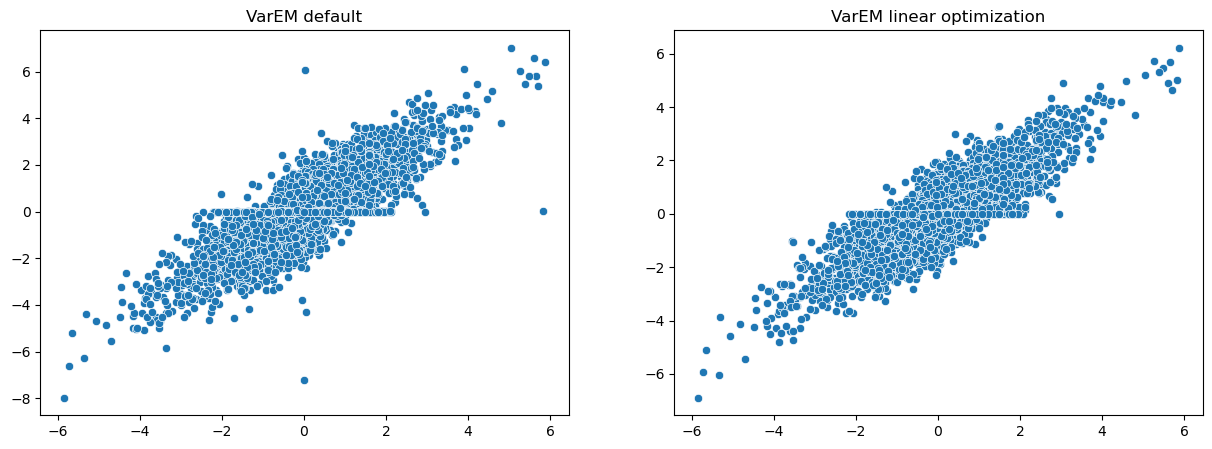

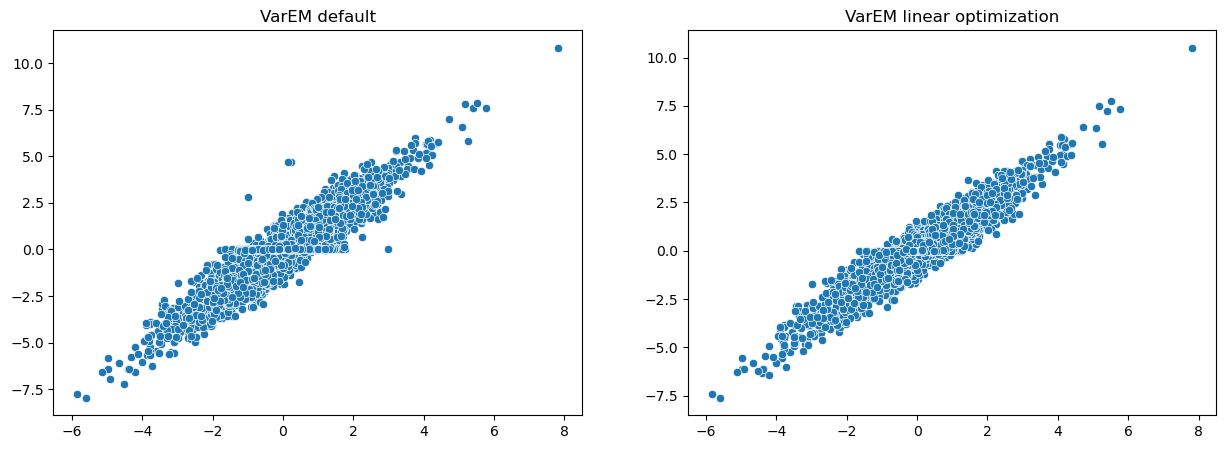

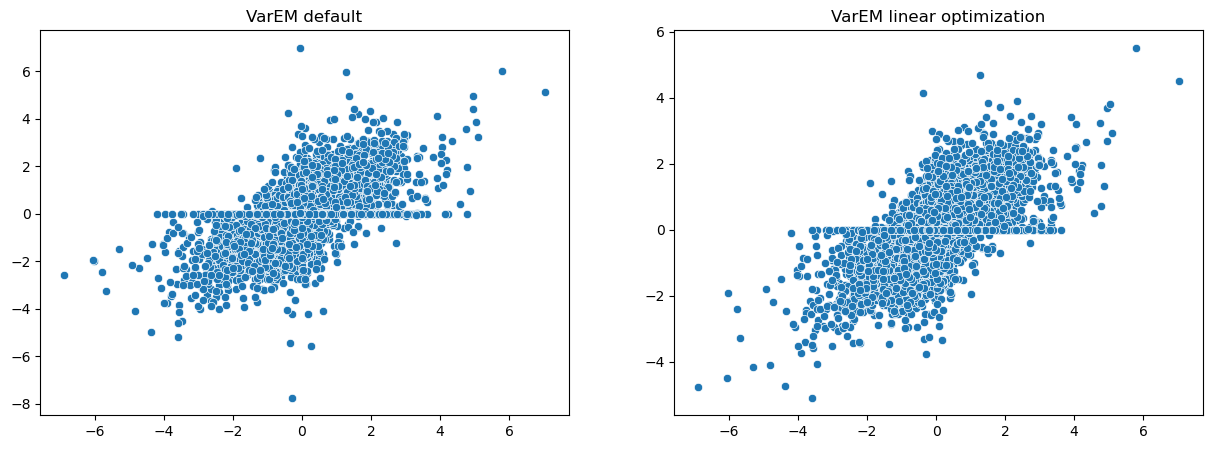

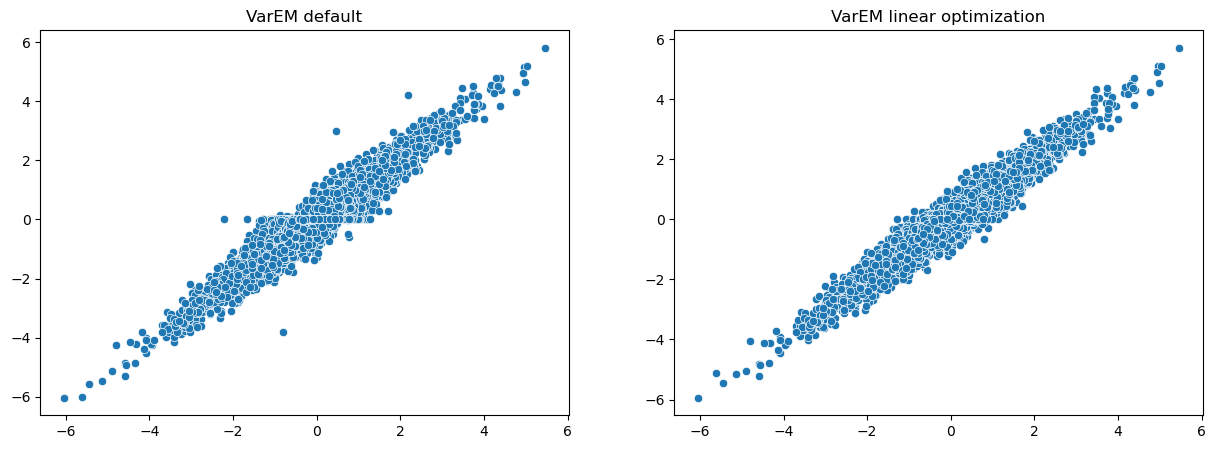

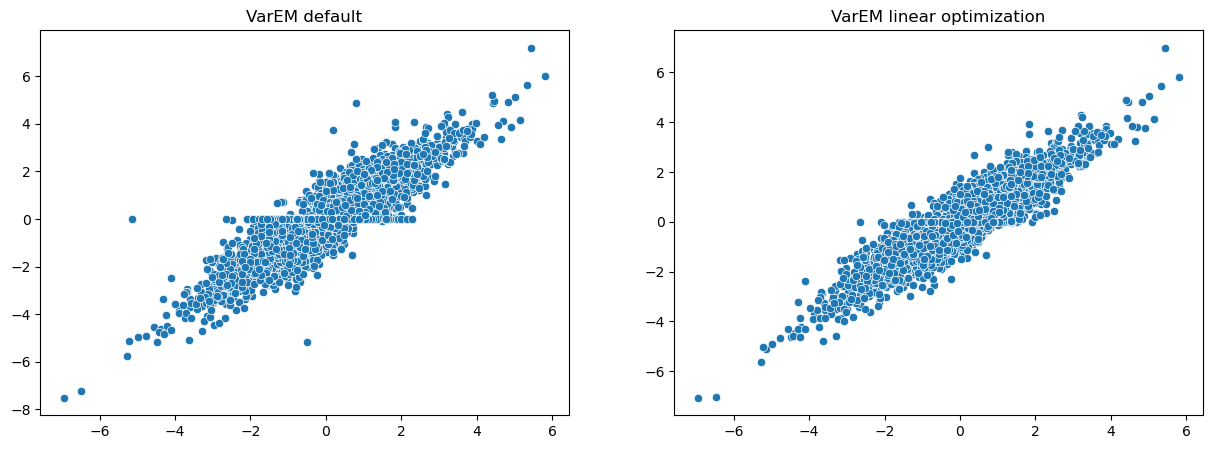

In [24]:
for i in range(J):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    sns.scatterplot(x = S.T[:,i], y = singals_estimation_VAR[:,i], ax = ax[0])
    sns.scatterplot(x = S.T[:,i], y = sc_est.Signals[:,i], ax = ax[1])
    ax[0].title.set_text('VarEM default')
    ax[1].title.set_text('VarEM linear optimization')
    plt.show()


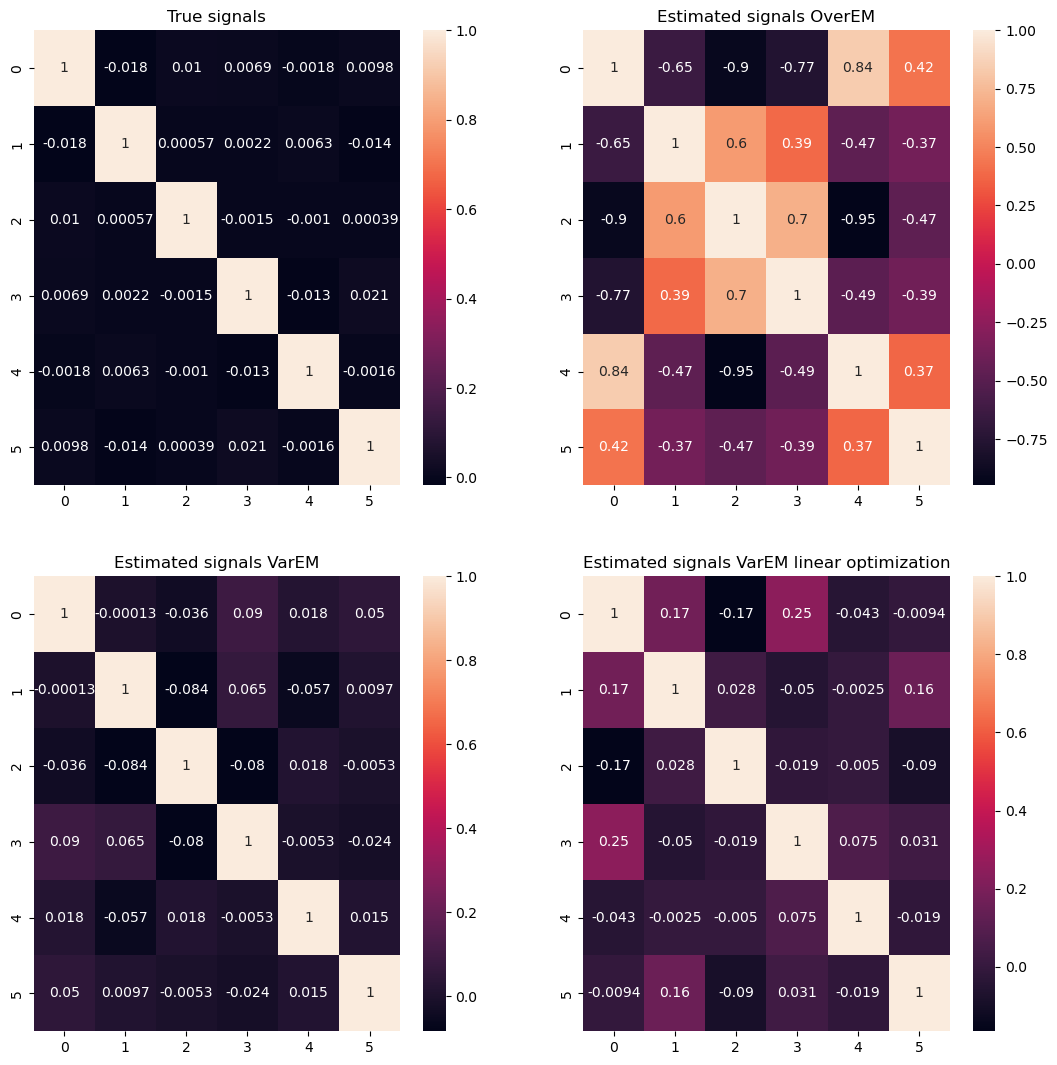

In [25]:
# plot correlation matrix of the signals
fig, ax = plt.subplots(2,2, figsize = (13,13))
sns.heatmap(np.corrcoef(S), annot=True, ax = ax[0,0])
ax[0,0].title.set_text('True signals')
sns.heatmap(np.corrcoef(singals_estimation_VAR.T), annot=True, ax = ax[1,0])
ax[1,0].title.set_text('Estimated signals VarEM')
sns.heatmap(np.corrcoef(singals_estimation_OVER.T), annot=True, ax = ax[0,1])
ax[0,1].title.set_text('Estimated signals OverEM')
sns.heatmap(np.corrcoef(sc_est.Signals.T), annot=True, ax = ax[1,1])
ax[1,1].title.set_text('Estimated signals VarEM linear optimization')
plt.show()

In [26]:
# how many rows have zero values
print("Zero values in the estimated signals")
print("VarEM")
print(np.sum(np.sum(np.round(singals_estimation_VAR, 3) == 0, axis = 1) > 0))
print("OverEM")
print(np.sum(np.sum(np.round(singals_estimation_OVER, 3) == 0, axis = 1) > 0))
print("VarEM linear optimization")
print(np.sum(np.sum(np.round(sc_est.Signals, 3) == 0, axis = 1) > 0))
print("True signals")
print(np.sum(np.sum(np.round(S.T, 3) == 0, axis = 1) > 0))

Zero values in the estimated signals
VarEM
5258
OverEM
45
VarEM linear optimization
10000
True signals
33
